## load base files

In [7]:
!git clone https://github.com/pedropro/TACO.git

fatal: destination path 'TACO' already exists and is not an empty directory.


In [10]:
%cd TACO
! python download.py
%cd ..

e:\applied_ai\deep_learning_2\project\TACO_object__detection\TACO
Note. If for any reason the connection is broken. Just call me again and I will start where I left.
Loading: [..............................] - 0/1500
Loading: [..............................] - 1/1500
Loading: [..............................] - 2/1500
Loading: [..............................] - 3/1500
Loading: [..............................] - 4/1500
Loading: [..............................] - 5/1500
Loading: [..............................] - 6/1500
Loading: [..............................] - 7/1500
Loading: [..............................] - 8/1500
Loading: [..............................] - 9/1500
Loading: [..............................] - 10/1500
Loading: [..............................] - 11/1500
Loading: [..............................] - 12/1500
Loading: [..............................] - 13/1500
Loading: [..............................] - 14/1500
Loading: [..............................] - 15/1500
Loading: [..

In [20]:
import os

# Check the number of batch folders downloaded
data_path = 'TACO/data/'
batches = [folder for folder in os.listdir(data_path) if folder.startswith('batch_')]
print(f"Total number of batches: {len(batches)}")

Total number of batches: 15


In [21]:
import json
import os

# Path to the annotations file
annotations_path = 'TACO/data/annotations.json'

# Check if the annotations file exists
if os.path.exists(annotations_path):
    with open(annotations_path, 'r') as f:
        data = json.load(f)

    # Get the number of images, categories, and annotations
    num_images = len(data['images'])  # List of images
    num_categories = len(data['categories'])  # List of categories
    num_annotations = len(data['annotations'])  # List of annotations

    print(f"Number of images: {num_images}")
    print(f"Number of categories: {num_categories}")
    print(f"Number of annotations: {num_annotations}")
else:
    print(f"Annotations file not found at: {annotations_path}")


Number of images: 1500
Number of categories: 60
Number of annotations: 4784


In [22]:
import json

# Load the annotations file
with open('TACO/data/annotations.json') as f:
    data = json.load(f)

## convert data into yolo format

In [124]:
import json
import os
from pathlib import Path
import shutil

# Paths to your TACO dataset
coco_json_path = 'TACO/data/annotations.json'  # Path to TACO's annotations file
images_dir = 'TACO/data'                       # Path to TACO's main image directory with batch subfolders
output_dir = 'yolo_top_categories'             # Base directory for YOLO format

# Ensure output directories for images and labels
Path(output_dir, 'images').mkdir(parents=True, exist_ok=True)
Path(output_dir, 'labels').mkdir(parents=True, exist_ok=True)

# Load TACO annotations
with open(coco_json_path, 'r') as f:
    data = json.load(f)

# Get category mappings
categories = {category['id']: category['name'] for category in data['categories']}

# Counter for unique filenames
file_counter = 1

# Process each image and corresponding annotations
for img in data['images']:
    img_id = img['id']
    img_file_name = img['file_name']  # This should be in the format 'batch_x/filename.jpg'
    img_width, img_height = img['width'], img['height']

    # Derive the image path within one of the 15 batch folders
    img_path = os.path.join(images_dir, img_file_name)

    # Create a unique integer-based name for each image and label
    unique_name = str(file_counter)
    img_extension = os.path.splitext(img_file_name)[1]  # Preserve the original extension (e.g., .jpg, .png)

    # Copy image to the images directory with the new unique name
    output_image_path = os.path.join(output_dir, 'images', unique_name + img_extension)
    if os.path.exists(img_path):
        shutil.copy(img_path, output_image_path)

        # Create a corresponding label file with the same unique integer name
        label_file_path = os.path.join(output_dir, 'labels', unique_name + '.txt')
        with open(label_file_path, 'w') as label_file:
            # Find all annotations for the current image
            for ann in data['annotations']:
                if ann['image_id'] == img_id:
                    category_id = ann['category_id']
                    # Ensure the category is in our mapping
                    if category_id in categories:
                        # YOLO format requires x_center, y_center, width, and height normalized
                        x, y, width, height = ann['bbox']
                        x_center = (x + width / 2) / img_width
                        y_center = (y + height / 2) / img_height
                        width /= img_width
                        height /= img_height

                        # Write the label file in YOLO format: <class_id> <x_center> <y_center> <width> <height>
                        label_file.write(f"{category_id} {x_center} {y_center} {width} {height}\n")

        # Increment the counter for the next file
        file_counter += 1

# Print the total number of images moved
print(f"Total number of images processed: {file_counter - 1}")

Total number of images processed: 1500


## deleting unwanted categories

In [125]:
import os
import json

# Step 1: Define the category mapping for the categories of interest
desired_categories = {
    36: 0,  # Plastic film
    58: 1,  # Unlabeled litter
    59: 2,  # Cigarette
    5: 3,   # Clear plastic bottle
    7: 4,   # Plastic bottle cap
    39: 5,  # Other plastic wrapper
    12: 6,  # Drink can
    29: 7,  # Other plastic
}

# Step 2: Define path to annotations and labels directory

label_dir = 'yolo_top_categories/labels'

# Step 3: Initialize counters for total images and deleted images
total_images = len(data['images'])
deleted_image_ids = set()

# Step 4: Loop through annotations and filter out unwanted categories
for ann in data['annotations']:
    if ann['category_id'] not in desired_categories:
        deleted_image_ids.add(ann['image_id'])  # Mark images to be deleted

# Step 5: Update the label files to reflect only desired categories and new IDs
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Read the original label data
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    # Prepare a list to hold the updated lines
    updated_lines = []

    # Process each line in the label file
    for line in lines:
        parts = line.strip().split()
        category_id = int(parts[0])

        # Check if the category ID is in the desired mapping
        if category_id in desired_categories:
            # Update the category ID to the new mapping
            new_category_id = desired_categories[category_id]

            # Create the updated line with the new category ID
            updated_line = f"{new_category_id} " + " ".join(parts[1:]) + "\n"
            updated_lines.append(updated_line)

    # Write the updated lines back to the label file
    with open(label_file_path, 'w') as file:
        file.writelines(updated_lines)

print("Label files have been updated with only the specified categories and new IDs.")

Label files have been updated with only the specified categories and new IDs.


## delete files that don't contain objects of interest

In [126]:
import os

# Path to the base directory containing unified 'images' and 'labels' folders
base_dir = 'yolo_top_categories'  # Adjust if necessary
label_dir = os.path.join(base_dir, 'labels')
image_dir = os.path.join(base_dir, 'images')

# Initialize a counter for deleted files
total_deleted_files = 0

# Loop over each label file in the labels directory
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Check if the label file is empty
    if os.path.getsize(label_file_path) == 0:
        # Construct possible image file paths
        base_image_name = os.path.splitext(label_file)[0]
        image_file_path_jpg = os.path.join(image_dir, base_image_name + '.jpg')
        image_file_path_jpg_upper = os.path.join(image_dir, base_image_name + '.JPG')

        # Delete the label file
        os.remove(label_file_path)
        total_deleted_files += 1

        # Delete the associated image file if it exists
        if os.path.exists(image_file_path_jpg):
            os.remove(image_file_path_jpg)
            total_deleted_files += 1
        elif os.path.exists(image_file_path_jpg_upper):
            os.remove(image_file_path_jpg_upper)
            total_deleted_files += 1

# Print the total number of files deleted
print(f"Total number of files deleted (label and image): {total_deleted_files}")

Total number of files deleted (label and image): 828


## split the data into train/val/test sections

In [127]:
import shutil
import random

random.seed(42)

# Set the split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Ensure output directories for each split
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(base_dir, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, 'labels'), exist_ok=True)

# Get a list of all images and shuffle them
all_images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
random.shuffle(all_images)

# Calculate split sizes
num_train = int(len(all_images) * train_ratio)
num_val = int(len(all_images) * val_ratio)

# Assign images to each split
train_images = all_images[:num_train]
val_images = all_images[num_train:num_train + num_val]
test_images = all_images[num_train + num_val:]

# Move files to their respective split directories
for split, images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
    for image_file in images:
        # Move image file
        src_image_path = os.path.join(image_dir, image_file)
        dst_image_path = os.path.join(base_dir, split, 'images', image_file)
        shutil.move(src_image_path, dst_image_path)

        # Move corresponding label file
        label_file = os.path.splitext(image_file)[0] + '.txt'
        src_label_path = os.path.join(label_dir, label_file)
        dst_label_path = os.path.join(base_dir, split, 'labels', label_file)
        if os.path.exists(src_label_path):  # Ensure corresponding label file exists
            shutil.move(src_label_path, dst_label_path)

# Print the number of images in each split
print(f"Number of images in train: {len(train_images)}")
print(f"Number of images in val: {len(val_images)}")
print(f"Number of images in test: {len(test_images)}")

Number of images in train: 760
Number of images in val: 217
Number of images in test: 109


## delete images under yolo_top_categories/images and labels

In [128]:
# Paths to the original images and labels directories
image_dir = os.path.join(base_dir, 'images')
label_dir = os.path.join(base_dir, 'labels')

# Delete the original images and labels directories
if os.path.exists(image_dir):
    shutil.rmtree(image_dir)

if os.path.exists(label_dir):
    shutil.rmtree(label_dir)

print("Original images and labels directories have been deleted.")

Original images and labels directories have been deleted.


## find largest size for all categories

In [129]:
import os

def find_largest_category(directory):
    value_per_category = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
    image_files = [f for f in os.listdir(os.path.join(directory, 'images')) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG')]

    for image_file in image_files:
      label_file = os.path.splitext(image_file)[0] + '.txt'
      label_path = os.path.join(directory, 'labels', label_file)

      if os.path.exists(label_path):
        with open(label_path, 'r') as f:
          lines = f.readlines()
          for line in lines:
            category = int(line.split()[0])
            if category in value_per_category:
              value_per_category[category] += 1

    largest_value = max(value_per_category.values())
    print(value_per_category)
    return largest_value

train_data_dir = 'yolo_top_categories/train'
largest_value = find_largest_category(train_data_dir)
print(largest_value)

{0: 337, 1: 368, 2: 496, 3: 199, 4: 141, 5: 191, 6: 149, 7: 193}
496


## copy the images to another directory

In [130]:
def copy_balanced_data(source_dir, dest_dir, max_samples_per_class):
  """
  Copies images and labels from source_dir to dest_dir, ensuring a balanced dataset
  with a maximum number of samples per class.
  """
  os.makedirs(os.path.join(dest_dir, 'images'), exist_ok=True)
  os.makedirs(os.path.join(dest_dir, 'labels'), exist_ok=True)

  class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
  image_files = [f for f in os.listdir(os.path.join(source_dir, 'images')) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG')]

  for image_file in image_files:
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(source_dir, 'labels', label_file)

    if os.path.exists(label_path):
      with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
          category = int(line.split()[0])
          if category in class_counts and class_counts[category] < max_samples_per_class:
            # Copy image
            src_image_path = os.path.join(source_dir, 'images', image_file)
            dst_image_path = os.path.join(dest_dir, 'images', image_file)
            shutil.copy(src_image_path, dst_image_path)

            # Copy label
            src_label_path = os.path.join(source_dir, 'labels', label_file)
            dst_label_path = os.path.join(dest_dir, 'labels', label_file)
            shutil.copy(src_label_path, dst_label_path)

            class_counts[category] += 1
            break  # Only consider the first class in the image

# Example usage
source_dir = 'yolo_top_categories/train'
dest_dir = 'yolo_top_categories/balanced_train'
max_samples_per_class = largest_value

copy_balanced_data(source_dir, dest_dir, max_samples_per_class)

## balance train dataset

In [131]:
def oversample_train_data(train_data_dir, largest_value):
    """Oversamples the training data to ensure a balanced dataset.

    Args:
        train_data_dir: Path to the training data directory.
        largest_value: The largest number of samples for any category in the train data.
    """

    label_dir = os.path.join(train_data_dir, 'labels')
    image_dir = os.path.join(train_data_dir, 'images')

    category_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
    for label_file in os.listdir(label_dir):
        label_path = os.path.join(label_dir, label_file)
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                category = int(line.split()[0])
                if category in category_counts:
                    category_counts[category] += 1

    for category, count in category_counts.items():
        if count < largest_value:
            num_to_duplicate = largest_value - count
            image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.JPG')]
            category_images = []
            for image_file in image_files:
                label_file = os.path.splitext(image_file)[0] + '.txt'
                label_path = os.path.join(label_dir, label_file)
                if os.path.exists(label_path):
                    with open(label_path, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            if int(line.split()[0]) == category:
                                category_images.append(image_file)
                                break

            for _ in range(num_to_duplicate):
                if category_images:
                    image_to_duplicate = random.choice(category_images)
                    new_image_name = str(uuid.uuid4()) + os.path.splitext(image_to_duplicate)[1]

                    src_image_path = os.path.join(image_dir, image_to_duplicate)
                    dst_image_path = os.path.join(image_dir, new_image_name)
                    shutil.copy(src_image_path, dst_image_path)

                    src_label_path = os.path.join(label_dir, os.path.splitext(image_to_duplicate)[0] + '.txt')
                    dst_label_path = os.path.join(label_dir, os.path.splitext(new_image_name)[0] + '.txt')
                    shutil.copy(src_label_path, dst_label_path)

# Example usage:
import uuid
train_data_dir = 'yolo_top_categories/balanced_train'
largest_value = find_largest_category(train_data_dir)
oversample_train_data(train_data_dir, largest_value)

{0: 337, 1: 368, 2: 496, 3: 199, 4: 141, 5: 191, 6: 149, 7: 193}


## ensure that all the categories are balanced

In [132]:
from collections import Counter
import matplotlib.pyplot as plt

# Function to plot label counts for a given split
def plot_label_counts(label_names, folders):
    # Loop through each split and calculate label distributions
    for split in folders:
        label_dir_split = os.path.join(base_dir, split, 'labels')

        # Initialize a counter for label counts for the current split
        label_counts = Counter()

        # Loop over each label file in the current label directory
        for label_file in os.listdir(label_dir_split):
            label_file_path = os.path.join(label_dir_split, label_file)

            # Read the label file
            with open(label_file_path, 'r') as file:
                lines = file.readlines()

                # Count each label in the file
                for line in lines:
                    parts = line.strip().split()
                    label_id = int(parts[0])  # The label ID is the first element
                    label_counts[label_id] += 1
        # Convert label IDs to label names and sort by count
        labels, counts = zip(*sorted(
            [(label_names[label_id], count) for label_id, count in label_counts.items()],
            key=lambda x: x[1]
        ))

        # Plotting a horizontal bar chart for the split
        plt.figure(figsize=(10, 6))
        plt.barh(labels, counts, color='skyblue')
        plt.xlabel("Count")
        plt.ylabel("Label Name")
        plt.title(f"Counts of Object Labels in {split.capitalize()} Dataset")
        plt.show()

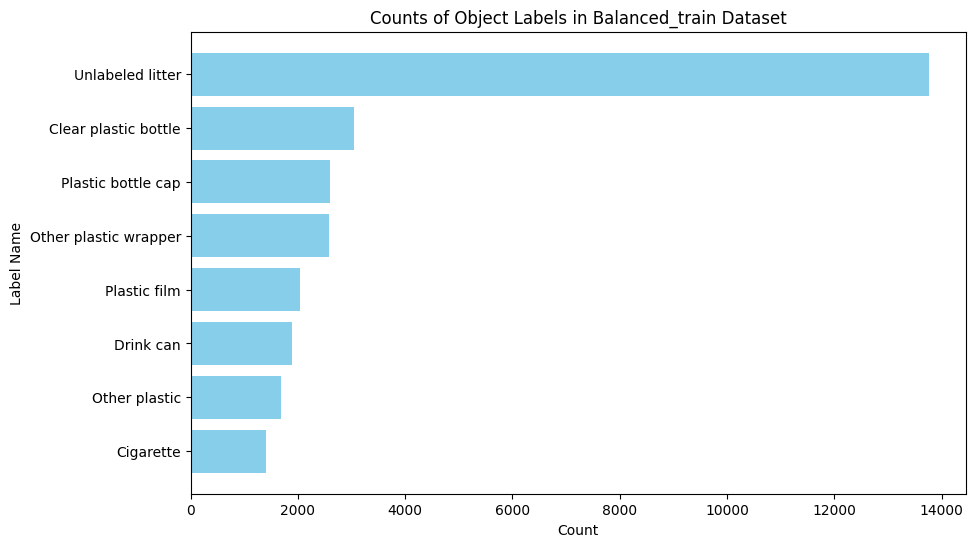

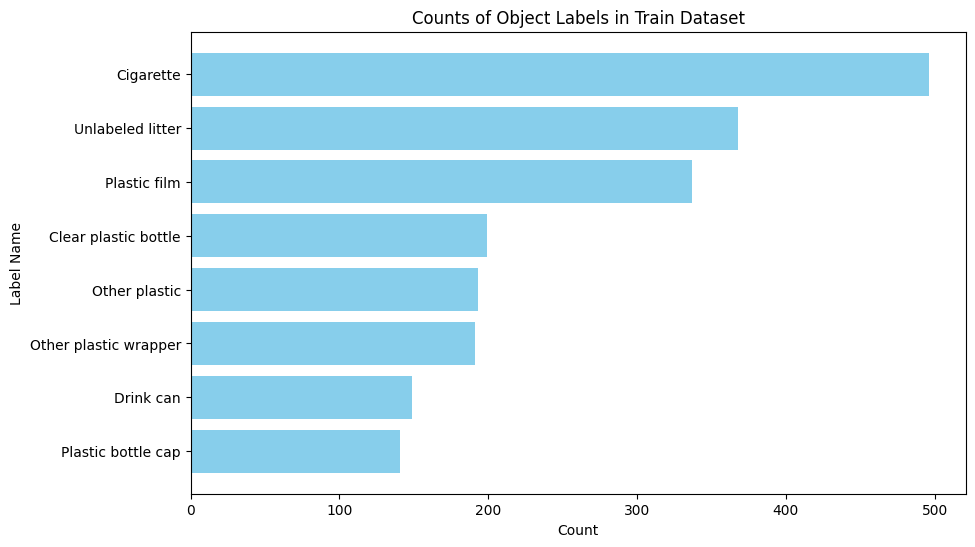

In [133]:
# Define a mapping from label IDs to names
label_names = {
    0: "Plastic film",
    1: "Unlabeled litter",
    2: "Cigarette",
    3: "Clear plastic bottle",
    4: "Plastic bottle cap",
    5: "Other plastic wrapper",
    6: "Drink can",
    7: "Other plastic",
}
# Plot label counts for the current split
plot_label_counts(label_names, ['balanced_train', 'train'])

In [134]:
def undersample_largest_class(train_data_dir):
  """Undersamples the class with the highest count in the training data.

  Args:
      train_data_dir: Path to the training data directory.
  """

  label_dir = os.path.join(train_data_dir, 'labels')
  image_dir = os.path.join(train_data_dir, 'images')

  category_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
  for label_file in os.listdir(label_dir):
      label_path = os.path.join(label_dir, label_file)
      with open(label_path, 'r') as f:
          lines = f.readlines()
          for line in lines:
              category = int(line.split()[0])
              if category in category_counts:
                  category_counts[category] += 1

  # Find the class with the largest count
  largest_class = max(category_counts, key=category_counts.get)
  largest_count = category_counts[largest_class]

  # Find the target count for undersampling (e.g., the second largest count)
  second_largest_count = sorted(category_counts.values())[-2] if len(category_counts) > 1 else largest_count

  # Remove images belonging to the largest class until its count matches the target count
  images_to_remove = []
  for image_file in os.listdir(image_dir):
      label_file = os.path.splitext(image_file)[0] + '.txt'
      label_path = os.path.join(label_dir, label_file)
      if os.path.exists(label_path):
          with open(label_path, 'r') as f:
              lines = f.readlines()
              for line in lines:
                  if int(line.split()[0]) == largest_class:
                      if category_counts[largest_class] > second_largest_count:
                          images_to_remove.append(image_file)
                          category_counts[largest_class] -= 1
                          break

  for image_file in images_to_remove:
      image_path = os.path.join(image_dir, image_file)
      label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
      if os.path.exists(image_path):
          os.remove(image_path)
      if os.path.exists(label_path):
          os.remove(label_path)

# Example usage:
train_data_dir = 'yolo_top_categories/balanced_train'
undersample_largest_class(train_data_dir)

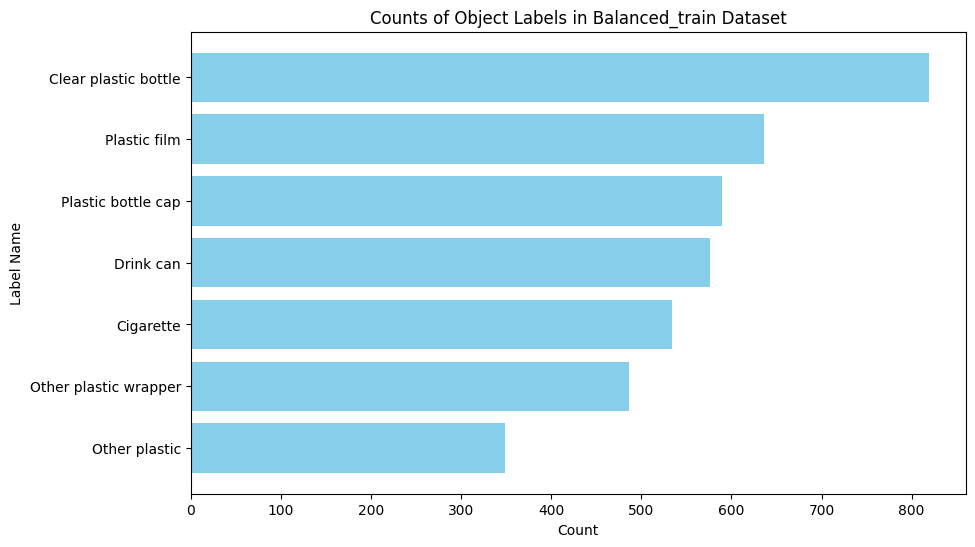

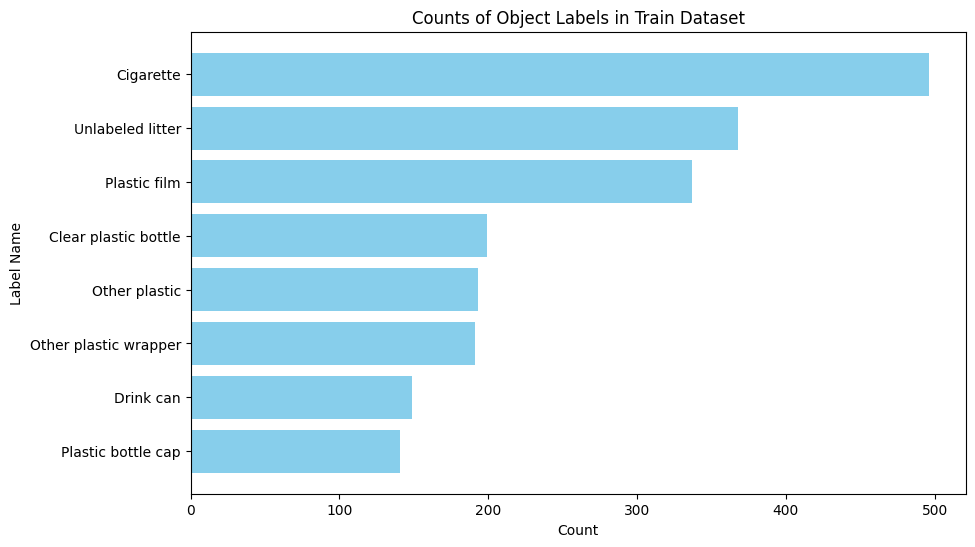

In [135]:
# Define a mapping from label IDs to names
label_names = {
    0: "Plastic film",
    1: "Unlabeled litter",
    2: "Cigarette",
    3: "Clear plastic bottle",
    4: "Plastic bottle cap",
    5: "Other plastic wrapper",
    6: "Drink can",
    7: "Other plastic",
}
# Plot label counts for the current split
plot_label_counts(label_names, ['balanced_train', 'train'])

In [136]:
import os
import json

# desired_categories = {
#     36: 0,  # Plastic film
#     58: 1,  # Unlabeled litter
#     59: 2,  # Cigarette
#     5: 3,   # Clear plastic bottle
#     7: 4,   # Plastic bottle cap
#     39: 5,  # Other plastic wrapper
#     12: 6,  # Drink can
#     29: 7,  # Other plastic
# }

# Step 1: Define the category mapping for the categories of interest
desired_categories = {
    0: 0,   # Plastic film
    1: 1,   # Unlabeled litter
    2: 2,   # Cigarette
    3: 3,   # Clear plastic bottle
    4: 4,   # Plastic bottle cap
    5: 5,   # Other plastic wrapper,
    6: 6,   # drink can
}

# Step 2: Define path to annotations and labels directory

label_dir = 'yolo_top_categories/balanced_train/labels'

# Step 3: Initialize counters for total images and deleted images
total_images = len(data['images'])
deleted_image_ids = set()

# Step 4: Loop through annotations and filter out unwanted categories
for ann in data['annotations']:
    if ann['category_id'] not in desired_categories:
        deleted_image_ids.add(ann['image_id'])  # Mark images to be deleted

# Step 5: Update the label files to reflect only desired categories and new IDs
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Read the original label data
    with open(label_file_path, 'r') as file:
        lines = file.readlines()

    # Prepare a list to hold the updated lines
    updated_lines = []

    # Process each line in the label file
    for line in lines:
        parts = line.strip().split()
        category_id = int(parts[0])

        # Check if the category ID is in the desired mapping
        if category_id in desired_categories:
            # Update the category ID to the new mapping
            new_category_id = desired_categories[category_id]

            # Create the updated line with the new category ID
            updated_line = f"{new_category_id} " + " ".join(parts[1:]) + "\n"
            updated_lines.append(updated_line)

    # Write the updated lines back to the label file
    with open(label_file_path, 'w') as file:
        file.writelines(updated_lines)

print("Label files have been updated with only the specified categories and new IDs.")

Label files have been updated with only the specified categories and new IDs.


In [137]:
import os

# Path to the base directory containing unified 'images' and 'labels' folders
base_dir = 'yolo_top_categories/balanced_train'  # Adjust if necessary
label_dir = os.path.join(base_dir, 'labels')
image_dir = os.path.join(base_dir, 'images')

# Initialize a counter for deleted files
total_deleted_files = 0

# Loop over each label file in the labels directory
for label_file in os.listdir(label_dir):
    label_file_path = os.path.join(label_dir, label_file)

    # Check if the label file is empty
    if os.path.getsize(label_file_path) == 0:
        # Construct possible image file paths
        base_image_name = os.path.splitext(label_file)[0]
        image_file_path_jpg = os.path.join(image_dir, base_image_name + '.jpg')
        image_file_path_jpg_upper = os.path.join(image_dir, base_image_name + '.JPG')

        # Delete the label file
        os.remove(label_file_path)
        total_deleted_files += 1

        # Delete the associated image file if it exists
        if os.path.exists(image_file_path_jpg):
            os.remove(image_file_path_jpg)
            total_deleted_files += 1
        elif os.path.exists(image_file_path_jpg_upper):
            os.remove(image_file_path_jpg_upper)
            total_deleted_files += 1

# Print the total number of files deleted
print(f"Total number of files deleted (label and image): {total_deleted_files}")

Total number of files deleted (label and image): 198


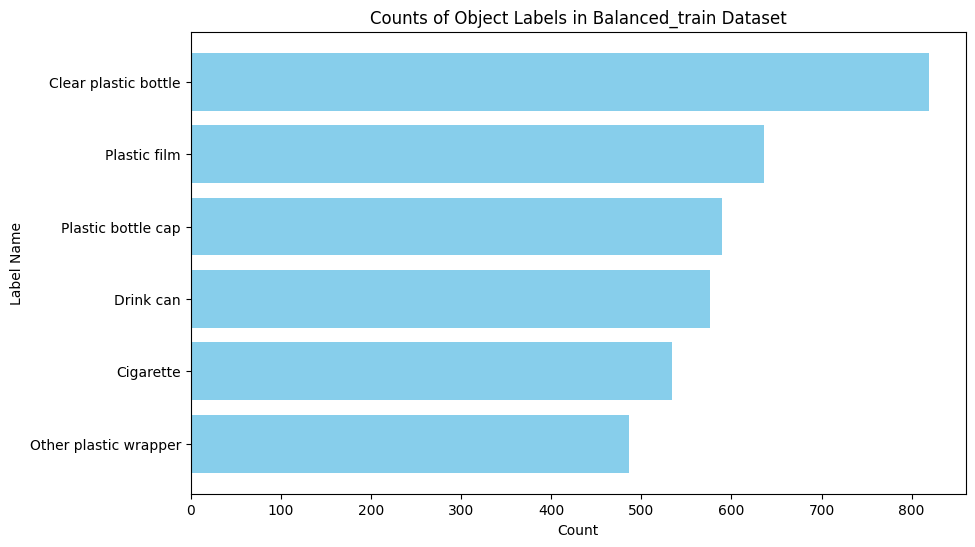

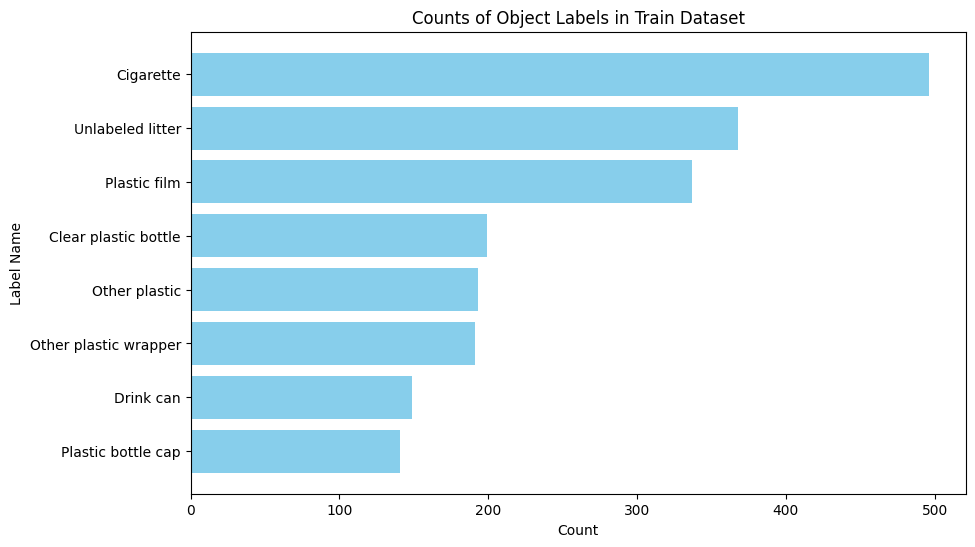

In [138]:
# Define a mapping from label IDs to names
base_dir = 'yolo_top_categories'
label_names = {
    0: "Plastic film",
    1: "Unlabeled litter",
    2: "Cigarette",
    3: "Clear plastic bottle",
    4: "Plastic bottle cap",
    5: "Other plastic wrapper",
    6: "Drink can",
    7: "Other plastic",
}
# Plot label counts for the current split
plot_label_counts(label_names, ['balanced_train', 'train'])

## model training

In [139]:
from ultralytics import YOLO

# change the model as needed
model = YOLO('yolov8l.pt')

results = model.train(data='data.yaml', cfg='hyp.yaml')

ModuleNotFoundError: No module named 'ultralytics'